In [1]:
import joblib

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [2]:
data = pd.read_csv("./data/copd.csv", index_col=0)
data = data.drop(columns=['copd'], axis=1)
data.head()

,ID,AGE,PackHistory,COPDSEVERITY,MWT1,MWT2,MWT1Best,FEV1,FEV1PRED,FVC,FVCPRED,CAT,HAD,SGRQ,AGEquartiles,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD
1,58,77,60.0,SEVERE,120.0,120.0,120.0,1.21,36.0,2.40,98,25,8.0,69.55,4,1,2,1,0,0,1,0
2,57,79,50.0,MODERATE,165.0,176.0,176.0,1.09,56.0,1.64,65,12,21.0,44.24,4,0,2,1,0,0,1,1
3,62,80,11.0,MODERATE,201.0,180.0,201.0,1.52,68.0,2.30,86,22,18.0,44.09,4,0,2,1,0,0,1,0
4,145,56,60.0,VERY SEVERE,210.0,210.0,210.0,0.47,14.0,1.14,27,28,26.0,62.04,1,1,2,0,0,1,1,0
5,136,65,68.0,SEVERE,204.0,210.0,210.0,1.07,42.0,2.91,98,32,18.0,75.56,1,1,2,0,1,1,0,0


In [3]:
data['COPDSEVERITY'].value_counts()

COPDSEVERITY
MODERATE       43
SEVERE         27
MILD           23
VERY SEVERE     8
Name: count, dtype: int64

**Note:** There is some imbalance. Proceed with accuracy as an initial evaluation metric, also used for hyperparameter tuning and reiterate if needed.

In [4]:
X = data.loc[:,data.columns!='COPDSEVERITY']
y = data['COPDSEVERITY']
print(X.shape, y.shape)

(101, 21) (101,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(70, 21) (31, 21) (70,) (31,)


In [6]:
data.columns.to_list()

['ID',
 'AGE',
 'PackHistory',
 'COPDSEVERITY',
 'MWT1',
 'MWT2',
 'MWT1Best',
 'FEV1',
 'FEV1PRED',
 'FVC',
 'FVCPRED',
 'CAT',
 'HAD',
 'SGRQ',
 'AGEquartiles',
 'gender',
 'smoking',
 'Diabetes',
 'muscular',
 'hypertension',
 'AtrialFib',
 'IHD']

In [7]:
X_train.isnull().sum()

ID              0
AGE             0
PackHistory     0
MWT1            2
MWT2            1
MWT1Best        1
FEV1            0
FEV1PRED        0
FVC             0
FVCPRED         0
CAT             0
HAD             0
SGRQ            0
AGEquartiles    0
gender          0
smoking         0
Diabetes        0
muscular        0
hypertension    0
AtrialFib       0
IHD             0
dtype: int64

Data Preprocessing

In [8]:
scale_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15]
cat_features = [13]

t = [('one_hot', OneHotEncoder(), cat_features), ('scale', MinMaxScaler(), scale_features)]
col_transform = ColumnTransformer(transformers=t, remainder='passthrough')

In [9]:
imputer = SimpleImputer(strategy='mean')

In [10]:
pipeline = Pipeline(steps=[('imp',imputer), ('preproc', col_transform)])

In [11]:
X_train.head()

,ID,AGE,PackHistory,MWT1,MWT2,MWT1Best,FEV1,FEV1PRED,FVC,FVCPRED,CAT,HAD,SGRQ,AGEquartiles,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD
1,58,77,60.0,120.0,120.0,120.0,1.21,36.0,2.40,98,25,8.0,69.55,4,1,2,1,0,0,1,0
47,122,64,90.0,416.0,390.0,416.0,1.26,44.0,2.10,58,18,15.0,42.01,1,1,2,0,0,1,0,0
11,166,76,6.0,226.0,240.0,240.0,1.10,46.0,2.06,75,31,20.0,55.56,3,0,2,1,1,0,1,0
55,164,72,34.0,427.0,432.0,432.0,0.73,37.0,1.47,62,23,11.0,32.47,3,0,2,1,1,0,0,0
42,116,75,10.0,370.0,396.0,396.0,0.92,50.0,2.29,102,13,12.0,54.49,3,0,2,0,0,0,0,0


In [12]:
X_train_proc = pipeline.fit_transform(X_train)

In [13]:
X_test_proc = pipeline.transform(X_test)

In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_new = label_encoder.fit_transform(y_train)

In [15]:
y_test_new = label_encoder.transform(y_test)

In [16]:
y_train.head()

1       SEVERE
47      SEVERE
11      SEVERE
55      SEVERE
42    MODERATE
Name: COPDSEVERITY, dtype: object

In [17]:
encoder_y = OneHotEncoder(sparse_output=False)
y_train_proc = encoder_y.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_train_proc.shape

(70, 4)

In [18]:
y_test_proc = encoder_y.fit_transform(y_test.to_numpy().reshape(-1, 1))
y_test_proc.shape

(31, 4)

In [19]:
def hp_tuning_grid(model, param_space, X_train, y_train):
    strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    gc_cv = GridSearchCV(model, param_space, cv = strat_cv, scoring="f1_macro", n_jobs=-1, verbose=1)
    gc_cv.fit(X_train, y_train)

    return gc_cv


def hp_tuning_rand(model, param_space, X_train, y_train):
    strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    rc_cv = RandomizedSearchCV(model, param_space, cv = strat_cv, scoring="f1_macro", n_iter=50, n_jobs=-1, verbose=1, random_state=42)
    rc_cv.fit(X_train, y_train)
    return rc_cv


def eval_optimal(opt_model, X_train, y_train, X_test, y_test):

    # Fit optimal model
    opt_model.fit(X_train, y_train)

    # Train set metrics
    y_pred_train = opt_model.predict(X_train).reshape((-1, 1))
    print('\nTraining set metrics')
    print(classification_report(y_train, y_pred_train, digits=4))

    # Test set metrics
    y_pred_test = opt_model.predict(X_test).reshape((-1, 1))
    print('\nTest set metrics')
    print(classification_report(y_test, y_pred_test, digits=4))
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest(X_train, y_train, X_test, y_test):

    n_estimators_values = np.array([10, 20, 30, 40])
    max_depth_values = np.array([2,3, 4, 5, 6, 7])
    min_samples_split_values = np.array([2, 3, 4, 5])
    min_samples_leaf_values = np.array([1, 2, 3, 4])
    max_features_values = np.array(['auto', 'sqrt'])
    param_space = {
        'n_estimators': n_estimators_values,
        'max_features': max_features_values,
        'max_depth': max_depth_values,
        'min_samples_split': min_samples_split_values,
        'min_samples_leaf': min_samples_leaf_values
    }

    rf = RandomForestClassifier(random_state=42)

    gc_cv = hp_tuning_grid(rf, param_space, X_train, y_train)

    print("Tuned Random Forest model parameters: {}".format(gc_cv.best_params_))

    # Optimal model
    n_estimators_opt = gc_cv.best_params_['n_estimators']
    max_depth_opt = gc_cv.best_params_['max_depth']
    min_samples_split_opt = gc_cv.best_params_['min_samples_split']
    min_samples_leaf_opt = gc_cv.best_params_['min_samples_leaf']
    max_features_opt = gc_cv.best_params_['max_features']
    rf_opt = RandomForestClassifier(n_estimators=n_estimators_opt,
                                    max_depth=max_depth_opt,
                                    min_samples_leaf=min_samples_leaf_opt,
                                    min_samples_split=min_samples_split_opt,
                                    max_features=max_features_opt)

    eval_optimal(rf_opt, X_train, y_train, X_test, y_test)

    return rf_opt

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


/home/tsoump/post_market/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
1920 fits failed out of a total of 3840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
519 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tsoump/post_market/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tsoump/post_market/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/home/tsoump/post_market/.venv/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_p

Tuned Random Forest model parameters: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}

Training set metrics
              precision    recall  f1-score   support

           0     0.9412    1.0000    0.9697        16
           1     0.9667    0.9667    0.9667        30
           2     1.0000    0.9474    0.9730        19
           3     1.0000    1.0000    1.0000         5

    accuracy                         0.9714        70
   macro avg     0.9770    0.9785    0.9773        70
weighted avg     0.9723    0.9714    0.9715        70


Test set metrics
              precision    recall  f1-score   support

           0     1.0000    0.8571    0.9231         7
           1     0.7857    0.8462    0.8148        13
           2     0.5455    0.7500    0.6316         8
           3     0.0000    0.0000    0.0000         3

    accuracy                         0.7419        31
   macro avg     0.5828    0.6133    0.5924        31

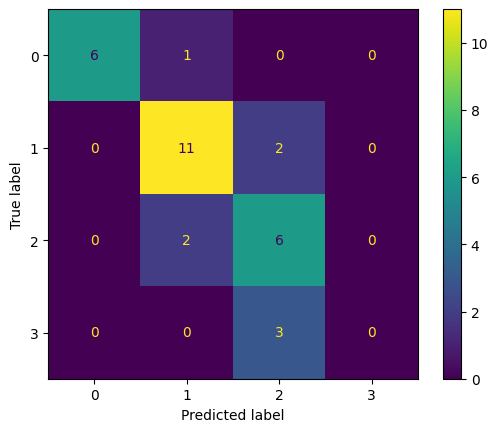

In [21]:
rf_opt = train_random_forest(X_train_proc, y_train_new, X_test_proc, y_test_new)

In [22]:
joblib.dump(rf_opt, "./models/random_forest.joblib")

['./models/random_forest.joblib']

### XGBoost

In [23]:
from sklearn.metrics import f1_score

def xgb_f1(y_true, predt, threshold=0.5):
    y_pred = np.argmax(predt, axis=1).astype(float)
    return f1_score(y_true,y_pred, average='macro')

In [24]:
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from scipy.stats import uniform, randint

def train_xgboost(X_train, y_train, X_test, y_test):
    param_space = {
        'max_depth': randint(low=3, high=8),
        'learning_rate': uniform(loc=1e-3, scale=0.5),
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.5, 0.6, 0.7, 0.8],
        'min_child_weight': [1, 3, 5],
        'gamma': uniform(),
        'lambda': uniform(loc=2, scale=8),
        'alpha': uniform(loc=2, scale=8),
        'n_estimators': randint(low=10, high=101)}
    
    xgb = XGBClassifier(objective='multi:softmax', eval_metric=xgb_f1, random_state=42)

    rc_cv = hp_tuning_rand(xgb, param_space, X_train, y_train)

    print("Tuned XGBoost model parameters: {}".format(rc_cv.best_params_))

    # Optimal model
    max_depth_opt = rc_cv.best_params_['max_depth']
    learning_rate_opt = rc_cv.best_params_['learning_rate']
    subsample_opt = rc_cv.best_params_['subsample']
    colsample_bytree_opt = rc_cv.best_params_['colsample_bytree']
    min_child_weight_opt = rc_cv.best_params_['min_child_weight']
    gamma_opt = rc_cv.best_params_['gamma']
    lambda_opt = rc_cv.best_params_['lambda']
    alpha_opt = rc_cv.best_params_['alpha']
    n_estimators_opt = rc_cv.best_params_['n_estimators']

    early_stopping = EarlyStopping(rounds=5, metric_name='xgb_f1', data_name='validation_2', maximize=True, save_best=True, min_delta=1e-3)

    xgb_opt = XGBClassifier(max_depth=max_depth_opt,
                            learning_rate=learning_rate_opt,
                            subsample=subsample_opt,
                            colsample_bytree=colsample_bytree_opt,
                            min_child_weight=min_child_weight_opt,
                            gamma=gamma_opt,
                            reg_lambda=lambda_opt,
                            alpha=alpha_opt,
                            n_estimators=n_estimators_opt,
                            eval_metric=xgb_f1,
                            callbacks=[early_stopping],
                            random_state=42
                            )
    
    X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    eval_set = [(X_train_xgb, y_train_xgb), (X_test, y_test), (X_val_xgb, y_val_xgb)]

    # Eary Stopping to avoid overfitting, 
    xgb_opt.fit(X_train_xgb, y_train_xgb, eval_set=eval_set, verbose=False)

    
    # Train set metrics
    y_pred_train = xgb_opt.predict(X_train).reshape((-1, 1))
    print('\nTraining set metrics')
    print(classification_report(y_train, y_pred_train, digits=4))
    cm = confusion_matrix(y_train, y_pred_train)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    # Test set metrics
    y_pred_test = xgb_opt.predict(X_test).reshape((-1, 1))
    print('\nTest set metrics')
    print(classification_report(y_test, y_pred_test, digits=4))
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    results = xgb_opt.evals_result()
    epochs = len(results['validation_0']['xgb_f1'])
    x_axis = range(0, epochs)

    # Learning curves
    _, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['xgb_f1'], label='Train')
    ax.plot(x_axis, results['validation_1']['xgb_f1'], label='Test')
    ax.plot(x_axis, results['validation_2']['xgb_f1'], label='Val')
    ax.legend()
    plt.xlabel('# of epochs')
    plt.ylabel('F1-score')
    plt.title('XGBoost learning curves')
    plt.show()

    return xgb_opt

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Tuned XGBoost model parameters: {'alpha': 2.781376912051071, 'colsample_bytree': 0.8, 'gamma': 0.24102546602601171, 'lambda': 7.466108150603666, 'learning_rate': 0.30599832889131046, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 90, 'subsample': 0.8}

Training set metrics
              precision    recall  f1-score   support

           0     1.0000    0.7500    0.8571        16
           1     0.8788    0.9667    0.9206        30
           2     0.7600    1.0000    0.8636        19
           3     0.0000    0.0000    0.0000         5

    accuracy                         0.8571        70
   macro avg     0.6597    0.6792    0.6604        70
weighted avg     0.8115    0.8571    0.8249        70



/home/tsoump/post_market/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tsoump/post_market/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tsoump/post_market/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

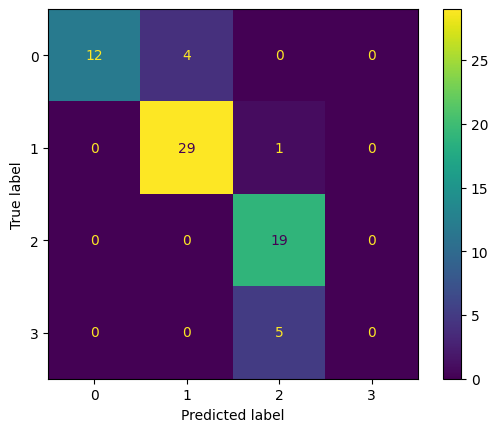


Test set metrics
              precision    recall  f1-score   support

           0     1.0000    0.8571    0.9231         7
           1     0.9286    1.0000    0.9630        13
           2     0.7273    1.0000    0.8421         8
           3     0.0000    0.0000    0.0000         3

    accuracy                         0.8710        31
   macro avg     0.6640    0.7143    0.6820        31
weighted avg     0.8029    0.8710    0.8296        31



/home/tsoump/post_market/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tsoump/post_market/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tsoump/post_market/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

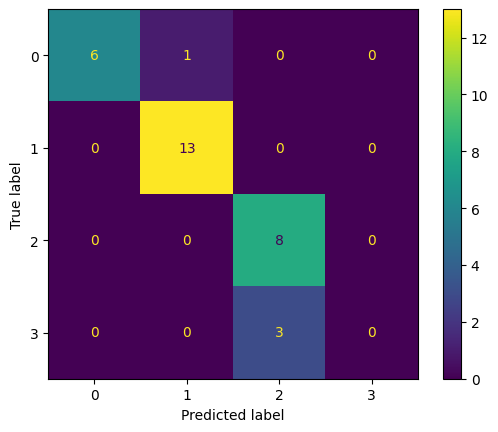

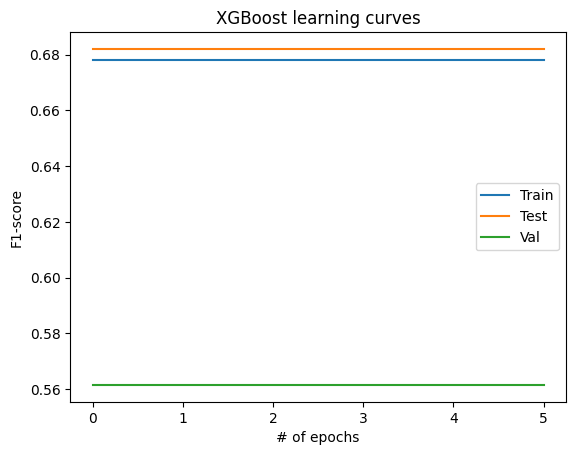

In [25]:
xgb_opt = train_xgboost(X_train_proc, y_train_new, X_test_proc, y_test_new)

In [26]:
joblib.dump(xgb_opt, "./models/xgboost.joblib")

['./models/xgboost.joblib']

### SVM

In [27]:
def train_svm(X_train, y_train, X_test, y_test):

    param_space = [
        {'C': [1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3], 'gamma': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf']},
    ]

    svm = SVC(random_state=42)

    gc_cv = hp_tuning_grid(svm, param_space, X_train, y_train)

    print("Tuned SVM model parameters: {}".format(gc_cv.best_params_))

    # Optimal model
    c_opt = gc_cv.best_params_['C']
    kernel_opt = gc_cv.best_params_['kernel']
    gamma_opt = gc_cv.best_params_['gamma']

    svm_opt = SVC(C=c_opt, kernel=kernel_opt, gamma=gamma_opt, random_state=42)
    eval_optimal(svm_opt, X_train, y_train, X_test, y_test)

    return svm_opt

Fitting 5 folds for each of 98 candidates, totalling 490 fits
Tuned SVM model parameters: {'C': 100.0, 'gamma': 0.001, 'kernel': 'linear'}

Training set metrics
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        16
           1     1.0000    1.0000    1.0000        30
           2     1.0000    1.0000    1.0000        19
           3     1.0000    1.0000    1.0000         5

    accuracy                         1.0000        70
   macro avg     1.0000    1.0000    1.0000        70
weighted avg     1.0000    1.0000    1.0000        70


Test set metrics
              precision    recall  f1-score   support

           0     0.7000    1.0000    0.8235         7
           1     0.7000    0.5385    0.6087        13
           2     0.5556    0.6250    0.5882         8
           3     0.5000    0.3333    0.4000         3

    accuracy                         0.6452        31
   macro avg     0.6139    0.6242    0.6051        31
weight

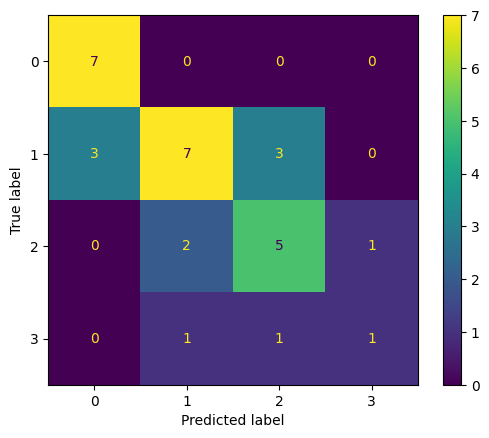

In [28]:
svm_opt = train_svm(X_train_proc, y_train_new, X_test_proc, y_test_new)

In [29]:
joblib.dump(svm_opt, "./models/svm.joblib")

['./models/svm.joblib']

### Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression

def train_logistic_regression(X_train, y_train, X_test, y_test):

    c_values = np.array([1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3])
    l1_ratio_values = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    param_space = {'l1_ratio': l1_ratio_values, 'C': c_values}

    lr = LogisticRegression(penalty='elasticnet', solver='saga', random_state=42)

    gc_cv = hp_tuning_grid(lr, param_space, X_train, y_train)

    print("Tuned Logistic Regression model parameters: {}".format(gc_cv.best_params_))

    # Optimal model
    c_opt = gc_cv.best_params_['C']
    l1_ratio_opt = gc_cv.best_params_['l1_ratio']
    lr_opt = LogisticRegression(l1_ratio=l1_ratio_opt, C=c_opt, penalty='elasticnet', solver='saga', random_state=42)

    eval_optimal(lr_opt, X_train, y_train, X_test, y_test)

    return lr_opt

Fitting 5 folds for each of 42 candidates, totalling 210 fits


/home/tsoump/post_market/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tsoump/post_market/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tsoump/post_market/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tsoump/post_market/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tsoump/post_market/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tsoump/post_market/

Tuned Logistic Regression model parameters: {'C': 10.0, 'l1_ratio': 0.4}

Training set metrics
              precision    recall  f1-score   support

           0     1.0000    0.8750    0.9333        16
           1     0.8824    1.0000    0.9375        30
           2     1.0000    0.8947    0.9444        19
           3     1.0000    1.0000    1.0000         5

    accuracy                         0.9429        70
   macro avg     0.9706    0.9424    0.9538        70
weighted avg     0.9496    0.9429    0.9429        70


Test set metrics
              precision    recall  f1-score   support

           0     0.6364    1.0000    0.7778         7
           1     0.7778    0.5385    0.6364        13
           2     0.5556    0.6250    0.5882         8
           3     0.5000    0.3333    0.4000         3

    accuracy                         0.6452        31
   macro avg     0.6174    0.6242    0.6006        31
weighted avg     0.6616    0.6452    0.6330        31



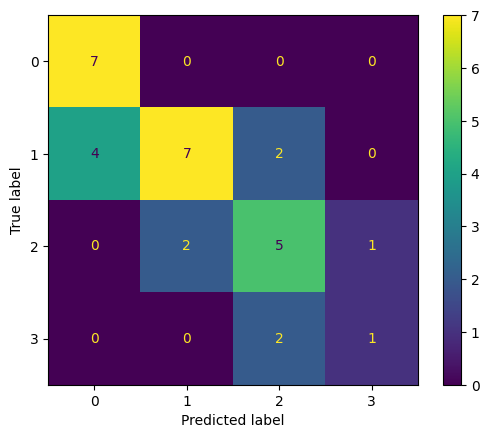

In [31]:
lr_opt = train_logistic_regression(X_train_proc, y_train_new, X_test_proc, y_test_new)

In [32]:
joblib.dump(lr_opt, "./models/logistic_regression.joblib")

['./models/logistic_regression.joblib']

### LightGBM

In [24]:
from lightgbm import LGBMClassifier

def train_lightgbm(X_train, y_train, X_test, y_test):

    param_space = {
        'lambda_l1': [0.01, 0.05, 0.1, 0.2, 0.5],
        'lambda_l2': [1, 5, 10, 15, 20],
        'bagging_fraction':  [0,4, 0.6, 0.8, 1.0],
        'feature_fraction': [0.4, 0.6, 0.8, 1.0],
        'bagging_freq': [10, 25, 40],
        'max_depth': [2, 3, 4],
        'num_leaves': [5, 8, 10, 15, 20],
        'min_data_in_leaf': [5, 10, 15, 20, 25],
        'learning_rate': [1e-3, 1e-2, 5e-2, 1e-1, 2e-1, 3e-1],
        'n_estimators': [5, 10, 15, 20, 25, 30, 35],
        'seed': [42]
    }

    lgbm = LGBMClassifier(objective='multiclass', verbose=-1, random_state=42)

    rc_cv = hp_tuning_rand(lgbm, param_space, X_train, y_train)

    print("Tuned LightGBM model parameters: {}".format(rc_cv.best_params_))

    # Optimal model
    lambda_l1_opt = rc_cv.best_params_['lambda_l1']
    lambda_l2_opt = rc_cv.best_params_['lambda_l2']
    bagging_fraction_opt = rc_cv.best_params_['bagging_fraction']
    feature_fraction_opt = rc_cv.best_params_['feature_fraction']
    bagging_freq_opt = rc_cv.best_params_['bagging_freq']
    max_depth_opt = rc_cv.best_params_['max_depth']
    num_leaves_opt = rc_cv.best_params_['num_leaves']
    min_data_in_leaf_opt = rc_cv.best_params_['min_data_in_leaf']
    learning_rate_opt = rc_cv.best_params_['learning_rate']
    n_estimators_opt = rc_cv.best_params_['n_estimators']
    seed = rc_cv.best_params_['seed']

    lgbm_opt = LGBMClassifier(
        objective='multiclass',
        lambda_l1=lambda_l1_opt,
        lambda_l2=lambda_l2_opt,
        bagging_fraction=bagging_fraction_opt,
        feature_fraction=feature_fraction_opt,
        bagging_freq=bagging_freq_opt,
        max_depth=max_depth_opt,
        num_leaves=num_leaves_opt,
        min_data_in_leaf=min_data_in_leaf_opt,
        learning_rate=learning_rate_opt,
        n_estimators=n_estimators_opt,
        seed=seed
    )

    eval_optimal(lgbm_opt, X_train, y_train, X_test, y_test)

    return lgbm_opt

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 365 .



Tuned LightGBM model parameters: {'seed': 42, 'num_leaves': 20, 'n_estimators': 15, 'min_data_in_leaf': 5, 'max_depth': 2, 'learning_rate': 0.3, 'lambda_l2': 15, 'lambda_l1': 0.5, 'feature_fraction': 1.0, 'bagging_freq': 40, 'bagging_fraction': 1.0}
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=40, subsample_freq=0 will be ignored. Current value: bagging_freq=40
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will 

/home/tsoump/post_market/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
90 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tsoump/post_market/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tsoump/post_market/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py", line 1187, in fit
    super().fit(
  File "/home/tsoump/post_market/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py", line 885, in fit
    self._Booster = train(
  File "/home/ts

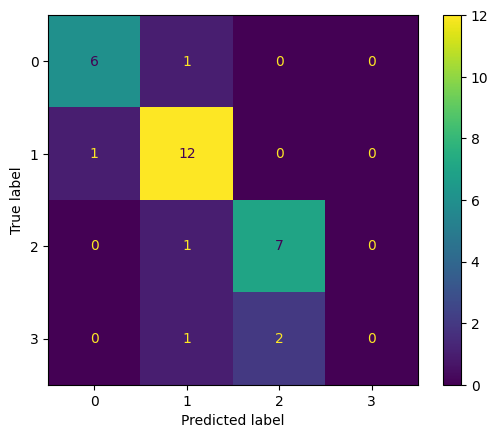

In [25]:
lgbm_opt = train_lightgbm(X_train_proc, y_train_new, X_test_proc, y_test_new)

In [26]:
joblib.dump(lgbm_opt, "./models/light_gbm.joblib")

['./models/light_gbm.joblib']

### CatBoost

In [29]:
from catboost import CatBoostClassifier

def train_catboost(X_train, y_train, X_test, y_test):

    param_space = {   
        'loss_function': ['MultiClass'],
        'eval_metric': ['TotalF1'],
        'iterations': [10, 50, 100],
        'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1, 3e-1],
        'l2_leaf_reg': [1e-2, 1e-1, 1, 1e1, 1e2],
        'depth': [2, 3, 4, 5],
        'min_data_in_leaf': [5, 10, 15, 20, 25], 
        'rsm': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'random_seed': [42]
    }

    cboost = CatBoostClassifier(objective='MultiClass', verbose=0)

    rc_cv = hp_tuning_rand(cboost, param_space, X_train, y_train)

    print("Tuned CatBoost model parameters: {}".format(rc_cv.best_params_))

    catboost_opt = CatBoostClassifier(**(rc_cv.best_params_))

    eval_optimal(catboost_opt, X_train, y_train, X_test, y_test)

    return catboost_opt

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Tuned CatBoost model parameters: {'rsm': 0.6, 'random_seed': 42, 'min_data_in_leaf': 10, 'loss_function': 'MultiClass', 'learning_rate': 0.3, 'l2_leaf_reg': 0.01, 'iterations': 100, 'eval_metric': 'TotalF1', 'depth': 2}
0:	learn: 0.4360772	total: 473us	remaining: 46.9ms
1:	learn: 0.6784997	total: 705us	remaining: 34.5ms
2:	learn: 0.8275751	total: 1.01ms	remaining: 32.7ms
3:	learn: 0.9109871	total: 1.24ms	remaining: 29.7ms
4:	learn: 0.9109125	total: 1.47ms	remaining: 27.8ms
5:	learn: 0.9109125	total: 1.69ms	remaining: 26.4ms
6:	learn: 0.9245179	total: 1.89ms	remaining: 25.2ms
7:	learn: 0.9259669	total: 2.08ms	remaining: 23.9ms
8:	learn: 0.9259669	total: 2.29ms	remaining: 23.1ms
9:	learn: 0.9395084	total: 2.48ms	remaining: 22.3ms
10:	learn: 0.9395084	total: 2.66ms	remaining: 21.5ms
11:	learn: 0.9395084	total: 2.87ms	remaining: 21ms
12:	learn: 0.9541724	total: 3.07ms	remaining: 20.5ms
13:	learn: 0.9541724	total: 3.23ms	remainin

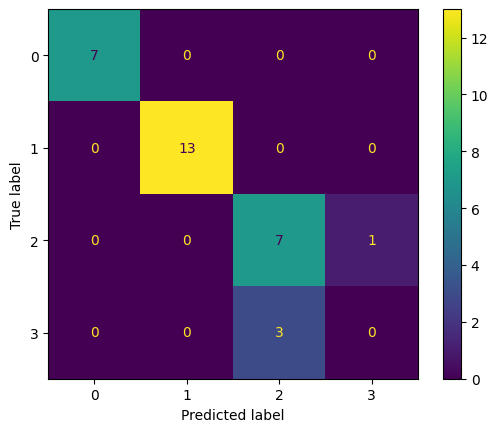

In [30]:
cboost_opt = train_catboost(X_train_proc, y_train_new, X_test_proc, y_test_new)

In [31]:
joblib.dump(cboost_opt, "./models/catboost.joblib")

['./models/catboost.joblib']